In [308]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import scanpy
import os
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pyroe
import itertools
import scipy.stats as stats
from pathlib import Path

In [309]:
def read_sim(simdir):
    cf = 'cells.tsv'
    gf = 'genes.tsv'
    mf = 'matrix.mtx'
    
    sim_raw = scanpy.read_mtx(os.path.sep.join([simdir, mf]))
    genes = [ l.rstrip() for l in open(os.path.sep.join([simdir, gf])).readlines() ]
    genes_df = pd.DataFrame(genes, columns=["gene_ids"])
    genes_df = genes_df.set_index("gene_ids")
    
    barcodes = [ l.rstrip() for l in open(os.path.sep.join([simdir, cf])).readlines()]
    barcodes_df = pd.DataFrame(barcodes, columns=["barcodes"])
    barcodes_df = barcodes_df.set_index("barcodes")
    
    mat = scanpy.AnnData(sim_raw.X, var=barcodes_df, obs=genes_df)
    mat = mat.T
    return mat



In [310]:
def sp_corr_df(d1, d2, shared, shared_cells, kind="cells", thresh=1):
    '''
    Given 2 AnnData objects, a list of shared genes `shared` and 
    a list of shared cells `shared_cells`, compute the pariwise spearman 
    correlation of type `kind`.  If `kind` is "cells", then compute the 
    cellwise spearman correlations, if it is "genes" compute the genewise
    spearman correlations.  The result is a distribution (list) of correlation
    values.
    '''
    a = d1[shared_cells, shared].X.copy()
    b = d2[shared_cells, shared].X.copy()
    if kind == "cells":
        corrs = np.zeros(len(shared_cells))
        for i,c in enumerate(shared_cells):
            sr,p = sp.stats.spearmanr(a[i,:].toarray()[0], b[i,:].toarray()[0])
            corrs[i]=sr
    elif kind == "genes":
        corrs = np.zeros(len(shared))
        a = a.T.tocsr()
        b = b.T.tocsr()
        corrs = np.zeros(len(shared))
        for i,c in enumerate(shared):
            sr,p = scipy.stats.spearmanr(a[i,:].toarray()[0], b[i,:].toarray()[0])
            corrs[i]=sr
    return corrs

In [311]:
def get_shared(list_of_annd):
    shared_cells = list_of_annd[0].obs_names
    shared_genes = list_of_annd[0].var_names
    for annd in list_of_annd[1:]:
        shared_cells &= annd.obs_names
        shared_genes &= annd.var_names 
    return shared_cells, shared_genes

In [312]:
def read_kb(ipath):
    mpath = os.path.sep.join([ipath,'cells_x_genes.mtx'])
    gpath = os.path.sep.join([ipath,'cells_x_genes.genes.txt'])
    bpath = os.path.sep.join([ipath,'cells_x_genes.barcodes.txt'])
    
    x = scanpy.read_mtx(mpath)
    bc = pd.read_csv(bpath, names=['barcodes'])
    g = pd.read_csv(gpath, names=['gene_ids'])
    g.gene_ids = g.gene_ids.str.split('.').str.get(0)
    bc = bc.set_index('barcodes')
    g = g.set_index('gene_ids')

    x.var = g
    x.obs = bc
    
    return x 

In [313]:
def read_solo(ipath):
    mtx_path = os.path.sep.join([ipath, 'matrix.mtx.gz'])
    if not Path(mtx_path).is_file():
        mtx_path_unzipped = mtx_path.rstrip('.gz')
        if not Path(mtx_path_unzipped).is_file():
            raise f"Cannot process data at {ipath}, matrix file is missing"
        else:
            raise f"Scanpy expects the matrix, features, and genes files to be gzipped"
    
    return scanpy.read_10x_mtx(ipath, var_names="gene_ids")

In [314]:
CELLS_AXIS = 1
GENES_AXIS = 0

In [315]:
mn = { 'kbd' : 'kallisto(D-list)|bustools', 'af' : 'alevin-fry(spliceu)', \
       'afi' : 'alevin-fry(splici)', 'ss' : 'STARsolo', \
       'kbd-hshmp' : 'kallisto(D-list)|bustools(HSHMP22)'
     }

In [316]:
fs_paths = json.load(open('notebook_paths.json'))
basedir = fs_paths["mouse_brain_root_path"]
HSHMP_nascent_fasta = fs_paths["GRCm39_HSHMP_nascent_fasta"]

#### Set up plotting asthetics

In [317]:
sns.set_style('white')
sns.set_context('talk')

### Mouse single-nuclei data analysis (E18)

#### relevant directories

In [318]:
fs_paths = json.load(open('notebook_paths.json'))
basedir = fs_paths["mouse_brain_root_path"]
HSHMP_nascent_fasta = fs_paths["GRCm39_HSHMP_nascent_fasta"]

In [319]:
### NEW
dirs = { 
    mn['kbd'] : os.path.sep.join([basedir, 'kallisto_bustools_using_spliceu_nasecent_transcripts_results/kb_quant/E18_brain/counts_unfiltered/']),
    mn['kbd-hshmp'] : os.path.sep.join([basedir, 'kallisto_bustools_using_HSHMP_nascent_transcripts_results/kb_quant/E18_brain/counts_unfiltered/']),
    mn['ss']: os.path.sep.join([basedir, 'starsolo_results/star_quant/E18_brain/Solo.out/GeneFull/raw/']),
    mn['af'] : os.path.sep.join([basedir, 'alevin_fry_spliceu_piscem_results/af_spliceu_piscem_quant/E18_brain/af_quant/']),
    mn['afi']: os.path.sep.join([basedir, 'alevin_fry_splici_results/af_splici_quant/E18_brain/af_quant/'])
}

#### Load the quantified data

In [320]:
# dictionary that will hold the different results
msn = {}

In [321]:
load_fn = {
    'kbd' : read_kb,
    'kbd-hshmp' : read_kb,
    'ss' : read_solo,
    'af' : lambda x : pyroe.load_fry(x, output_format={'X' : ['U', 'A'], 'spliced' : ['S'], 'unspliced' : ['U'], 'ambiguous' : ['A']}),
    'afi' : lambda x : pyroe.load_fry(x, output_format='snRNA')
}

In [322]:
!wget -O e18_barcodes.tsv https://umd.box.com/shared/static/teohgo005zmoq3ha2zxrzviffduvre7w.tsv

--2023-01-04 01:01:53--  https://umd.box.com/shared/static/teohgo005zmoq3ha2zxrzviffduvre7w.tsv
Resolving umd.box.com (umd.box.com)... 74.112.186.144
Connecting to umd.box.com (umd.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/teohgo005zmoq3ha2zxrzviffduvre7w.tsv [following]
--2023-01-04 01:01:53--  https://umd.box.com/public/static/teohgo005zmoq3ha2zxrzviffduvre7w.tsv
Reusing existing connection to umd.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://umd.app.box.com/public/static/teohgo005zmoq3ha2zxrzviffduvre7w.tsv [following]
--2023-01-04 01:01:53--  https://umd.app.box.com/public/static/teohgo005zmoq3ha2zxrzviffduvre7w.tsv
Resolving umd.app.box.com (umd.app.box.com)... 74.112.186.144
Connecting to umd.app.box.com (umd.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl2.boxcloud.com/d/1/b1!B

In [334]:
# high confidence barcode set --- the first row is a description, so skip and rename it
msn_hq_cells = pd.read_table('e18_barcodes.tsv', names=['hq_bc'], skiprows=1)

In [324]:
for k,v in mn.items():
    print(f"loading dataset for {v}")
    msn[v] = load_fn[k](dirs[v])

loading dataset for kallisto(D-list)|bustools
loading dataset for alevin-fry(spliceu)
USA mode: True
Processing user-defined output format.
Will populate output field X with sum of counts frorm ['U', 'A'].
Will combine ['S'] into output layer spliced.
Will combine ['U'] into output layer unspliced.
Will combine ['A'] into output layer ambiguous.
loading dataset for alevin-fry(splici)
USA mode: True
Using pre-defined output format: snrna
Will populate output field X with sum of counts frorm ['U', 'S', 'A'].
loading dataset for STARsolo
loading dataset for kallisto(D-list)|bustools(HSHMP22)


In [325]:
shared_cells_all, shared_genes_all = get_shared( list(msn.values()) )

#### Look at statistics for unspliced / spliced and ambiguous UMI count

In [326]:
assignment_type = pd.DataFrame.from_records(list(map(lambda x: (x, msn[mn['af']].layers[x].sum()), msn[mn['af']].layers)), \
                         columns=['UMI assignment', 'count'])
assignment_type = assignment_type.replace({'unspliced' : 'Unspliced', 'spliced' : 'Spliced', 'ambiguous' : 'Ambiguous'})

In [327]:
assignment_type

,UMI assignment,count
0,Ambiguous,21852072.0
1,Unspliced,17383240.0
2,Spliced,4381982.0


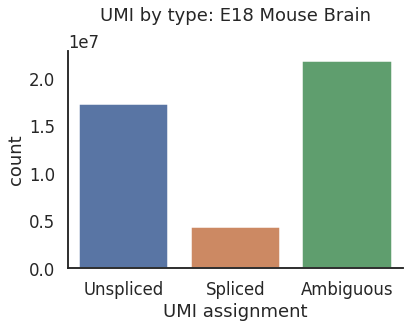

In [328]:
sns.barplot(data=assignment_type, x='UMI assignment', y='count', order=['Unspliced', 'Spliced', 'Ambiguous'])
plt.title('UMI by type: E18 Mouse Brain', pad=30)
sns.despine()
plt.savefig('plots/e18_umi_type.pdf', bbox_inches='tight')

#### Get the strand information for each gene

In [329]:
HSHMP_fasta = HSHMP_nascent_fasta
strand_data = []
with open(HSHMP_fasta) as ifile:
    for l in ifile:
        if l.startswith('>'):
            toks = l.split()
            name = toks[0].strip('>')
            strand = toks[-1].strip('strand')
            strand_data.append((name, strand))

strand_df = pd.DataFrame.from_records(strand_data, columns=['name', 'strand'])
strand_df.set_index('name', inplace=True)

#### Aggregate counts by genes and cells

In [335]:
cell_umi_totals = pd.DataFrame( data= {
    mn['kbd'] : np.squeeze(np.asarray(msn[mn['kbd']][msn_hq_cells['hq_bc'], shared_genes_all].X.sum(axis=CELLS_AXIS))),
    mn['kbd-hshmp'] : np.squeeze(np.asarray(msn[mn['kbd-hshmp']][msn_hq_cells['hq_bc'], shared_genes_all].X.sum(axis=CELLS_AXIS))),
    mn['ss'] : np.squeeze(np.asarray(msn[mn['ss']][msn_hq_cells['hq_bc'], shared_genes_all].X.sum(axis=CELLS_AXIS))),
    mn['af'] : np.squeeze(np.asarray(msn[mn['af']][msn_hq_cells['hq_bc'], shared_genes_all].X.sum(axis=CELLS_AXIS))),
    mn['afi']: np.squeeze(np.asarray(msn[mn['afi']][msn_hq_cells['hq_bc'], shared_genes_all].X.sum(axis=CELLS_AXIS)))
})

In [336]:
cell_umi_totals.corr(method='spearman')

,kallisto(D-list)|bustools,kallisto(D-list)|bustools(HSHMP22),STARsolo,alevin-fry(spliceu),alevin-fry(splici)
kallisto(D-list)|bustools,1.000000,0.966392,0.999608,0.998934,0.999666
kallisto(D-list)|bustools(HSHMP22),0.966392,1.000000,0.964740,0.970085,0.964397
STARsolo,0.999608,0.964740,1.000000,0.998119,0.999918
alevin-fry(spliceu),0.998934,0.970085,0.998119,1.000000,0.998263
alevin-fry(splici),0.999666,0.964397,0.999918,0.998263,1.000000


In [337]:
cell_umi_totals.corr(method='pearson')

,kallisto(D-list)|bustools,kallisto(D-list)|bustools(HSHMP22),STARsolo,alevin-fry(spliceu),alevin-fry(splici)
kallisto(D-list)|bustools,1.000000,0.969431,0.999084,0.999061,0.999501
kallisto(D-list)|bustools(HSHMP22),0.969431,1.000000,0.962521,0.974877,0.963895
STARsolo,0.999084,0.962521,1.000000,0.996843,0.999865
alevin-fry(spliceu),0.999061,0.974877,0.996843,1.000000,0.997637
alevin-fry(splici),0.999501,0.963895,0.999865,0.997637,1.000000


In [338]:
corr_dfs = {}

In [339]:
meth_list = list(mn.values())

In [340]:
for m1, m2 in itertools.combinations(meth_list,2):
    k = f"{m1} vs. {m2}"
    corr_dfs[k] = sp_corr_df(msn[m1], msn[m2], shared_genes_all, msn_hq_cells['hq_bc'])

In [341]:
corr_dfs_pd = pd.DataFrame( data = corr_dfs)

In [342]:
corr_dfs_pd.mean()

kallisto(D-list)|bustools vs. alevin-fry(spliceu)                   0.952503
kallisto(D-list)|bustools vs. alevin-fry(splici)                    0.943954
kallisto(D-list)|bustools vs. STARsolo                              0.942215
kallisto(D-list)|bustools vs. kallisto(D-list)|bustools(HSHMP22)    0.671051
alevin-fry(spliceu) vs. alevin-fry(splici)                          0.968809
alevin-fry(spliceu) vs. STARsolo                                    0.927687
alevin-fry(spliceu) vs. kallisto(D-list)|bustools(HSHMP22)          0.649376
alevin-fry(splici) vs. STARsolo                                     0.955768
alevin-fry(splici) vs. kallisto(D-list)|bustools(HSHMP22)           0.644964
STARsolo vs. kallisto(D-list)|bustools(HSHMP22)                     0.647560
dtype: float64

In [343]:
## Set up the colors for the distribution plots below
HSHMP_cols = sorted([y for y in corr_dfs_pd.columns if y.split(' vs. ')[-1] == mn['kbd-hshmp']], \
                    key=str.lower)
other_cols = sorted(list(set(corr_dfs_pd.columns) - set(HSHMP_cols)), \
                    key=str.lower)

col_order = other_cols + HSHMP_cols

colors = dict([ (x, 'r') if x in HSHMP_cols else (x, 'gray') for x in corr_dfs_pd.columns])

In [344]:
adult_corrs = pd.read_table('adult_mouse_brain_correlations.tsv', sep='\t')

In [345]:
adult_corrs['dataset'] = 'Adult'

In [346]:
corr_dfs_pd['dataset'] = 'E18'

In [347]:
d = pd.concat([corr_dfs_pd, adult_corrs]).drop('Unnamed: 0', axis=1)

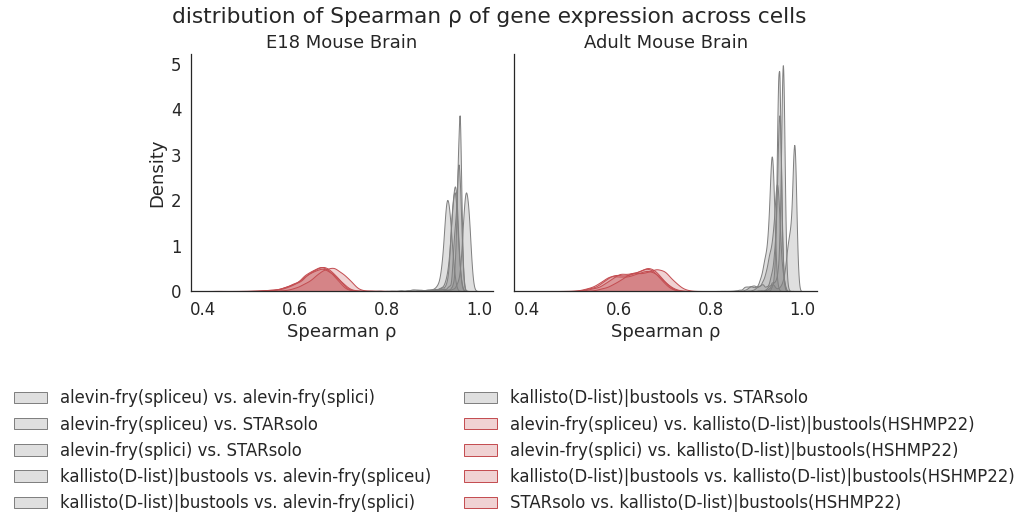

In [348]:
## plot the distributions of expresion correlations over all cells
sns.set(font_scale=1.5)
sns.set_style('white')
ax = sns.displot(d.melt(id_vars='dataset').rename(columns={'value': 'Spearman ⍴'}), x='Spearman ⍴', hue='variable', col='dataset', fill=True, kind="kde", color='gray', palette=colors, hue_order=col_order)
ax.axes_dict['E18'].set_title('E18 Mouse Brain')
ax.axes_dict['Adult'].set_title('Adult Mouse Brain')

ax.fig.subplots_adjust(top=0.85) # adjust the Figure in rp
ax.fig.suptitle('distribution of Spearman ⍴ of gene expression across cells', x=0.28)
ax.fig

sns.move_legend(
    ax, "upper center",
    bbox_to_anchor=(0.3, -0.04), ncol=2, title=None, frameon=False,
)
plt.savefig('plots/e18_and_adult_spearman_dist.pdf', bbox_inches='tight')

/home/rob/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/rob/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


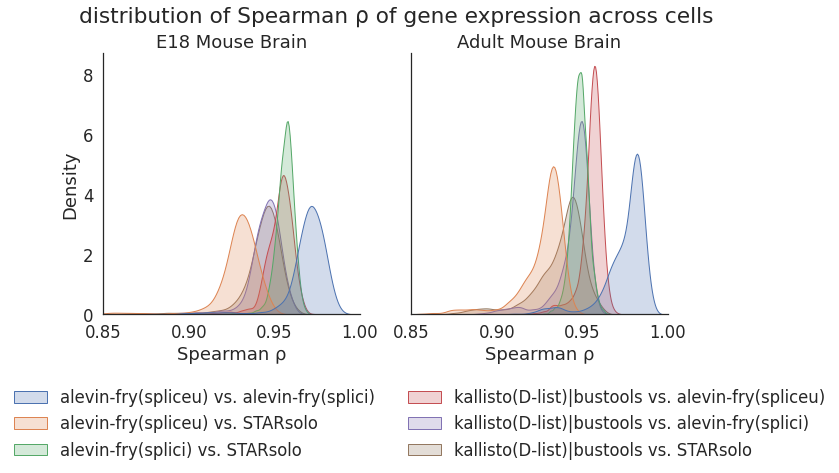

In [349]:
## plot the distributions of expresion correlations over all cells
sns.set(font_scale=1.5)
sns.set_style('white')
filt_mn = [m for m in corr_dfs.keys() if m.find(mn['kbd-hshmp']) == -1]
filt_mn = sorted(filt_mn, key=str.lower)
filt_mn.append('dataset')

ax = sns.displot( pd.concat([corr_dfs_pd[filt_mn], adult_corrs[filt_mn]]).melt(id_vars='dataset').rename(columns={'value': 'Spearman ⍴'})\
            , x='Spearman ⍴', col='dataset', fill=True, kind="kde", hue='variable', hue_order=filt_mn[:-1],\
            facet_kws=dict(gridspec_kws=dict(wspace=0.2)))
ax.axes_dict['E18'].set_title('E18 Mouse Brain')
ax.axes_dict['Adult'].set_title('Adult Mouse Brain')

plt.xlim((0.85,1))
ax.fig.subplots_adjust(top=0.85) # adjust the Figure in rp
ax.fig.suptitle('distribution of Spearman ⍴ of gene expression across cells', x=0.38)

sns.move_legend(
    ax, "upper center",
    bbox_to_anchor=(0.4, -0.04), ncol=2, title=None, frameon=False,
)
plt.savefig('plots/e18_and_adult_spearman_dist_no_hshmp.pdf', bbox_inches='tight')

In [350]:
fw_genes = strand_df.loc[strand_df.strand == '+'].index

In [351]:
gene_umi_totals = pd.DataFrame( data= dict(\
     {k : np.squeeze(np.asarray(msn[k][msn_hq_cells['hq_bc'], shared_genes_all].X.sum(axis=GENES_AXIS))) \
     for k in msn.keys() },\
     **{ 'strand': strand_df.loc[shared_genes_all.values]['strand']}))

In [352]:
gene_umi_totals.corr(method='spearman')

,kallisto(D-list)|bustools,alevin-fry(spliceu),alevin-fry(splici),STARsolo,kallisto(D-list)|bustools(HSHMP22)
kallisto(D-list)|bustools,1.000000,0.901480,0.899966,0.951811,0.858055
alevin-fry(spliceu),0.901480,1.000000,0.996355,0.880889,0.795373
alevin-fry(splici),0.899966,0.996355,1.000000,0.879584,0.794674
STARsolo,0.951811,0.880889,0.879584,1.000000,0.835466
kallisto(D-list)|bustools(HSHMP22),0.858055,0.795373,0.794674,0.835466,1.000000


In [353]:
gene_umi_totals.corr(method='pearson')

,kallisto(D-list)|bustools,alevin-fry(spliceu),alevin-fry(splici),STARsolo,kallisto(D-list)|bustools(HSHMP22)
kallisto(D-list)|bustools,1.000000,0.994202,0.993503,0.994246,0.407445
alevin-fry(spliceu),0.994202,1.000000,0.996211,0.989930,0.393840
alevin-fry(splici),0.993503,0.996211,1.000000,0.994103,0.394925
STARsolo,0.994246,0.989930,0.994103,1.000000,0.391494
kallisto(D-list)|bustools(HSHMP22),0.407445,0.393840,0.394925,0.391494,1.000000


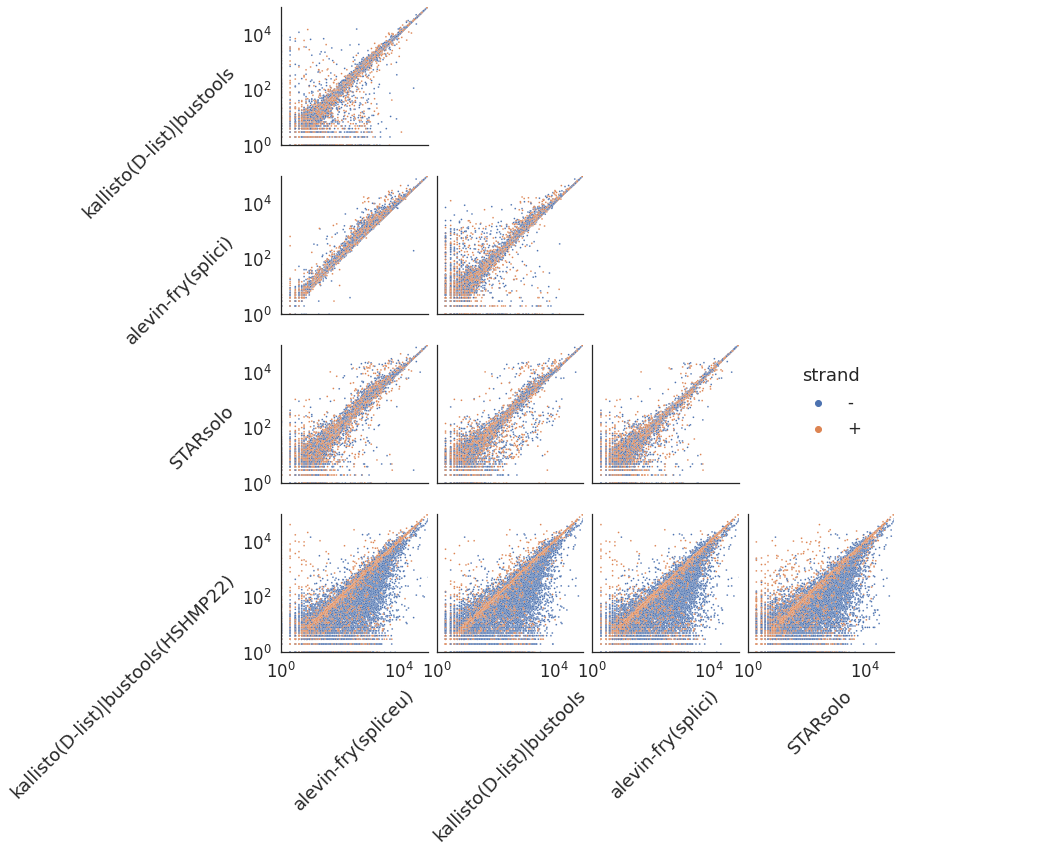

In [354]:
pp = sns.pairplot(data=\
             pd.concat([gene_umi_totals[ [mn[m] for m in ['af', 'kbd', 'kbd-hshmp', 'ss', 'afi']] ], \
                       gene_umi_totals['strand']], axis=1), \
             x_vars = [mn[m] for m in ['af', 'kbd', 'afi', 'ss', 'kbd-hshmp']],
             y_vars = [mn[m] for m in ['af', 'kbd', 'afi', 'ss', 'kbd-hshmp']],
             hue = 'strand',
             diag_kind='kde', diag_kws={"linewidth": 0, "shade": False},
             corner=True, plot_kws={'s' : 3})

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

pp.map_diag(hide_current_axis)

did_log = { 'x' : {}, 'y' : {} }
for ax in pp.axes.flatten():
    if ax is not None:
        xl = ax.get_xlabel()
        yl = ax.get_ylabel()
        if len(xl) > 0 and len(yl) > 0 and xl != yl:
            if xl not in did_log['x']:
                ax.set(xscale="log")
                ax.set_xlim((1, 100000))
                did_log['x'] = xl
            if yl not in did_log['y']:
                ax.set(yscale="log")
                ax.set_ylim((1, 100000))
                did_log['y'] = yl
        else:
            ax.set_visible(False)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)    
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation=45)
        # rotate y axis labels
        ax.set_ylabel(ax.get_ylabel(), rotation=45)
        # set y labels alignment
        ax.yaxis.get_label().set_horizontalalignment('right')

pp._legend.set_bbox_to_anchor((0.9, 0.5))
plt.savefig('plots/e18_pairwise_scatter.png', bbox_inches='tight')